# ACGAN with Wasserstein Gradient Penalty and Spectral Normalization

In [1]:
import torch
import torch.nn as nn
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.transforms import v2 as transforms
import torchvision
import cv2
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.utils import spectral_norm
import torch.nn.functional as F
from piq import FID, KID, PR
import time as t
#plt.switch_backend('agg')
from torchvision import utils
import tensorflow as tf
from torch import autograd
from itertools import chain
import wandb

### Helper functions

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [3]:
def compute_acc(preds, labels):
    correct = 0
    preds_ = preds.data.max(1)[1]
    correct = preds_.eq(labels.data).cpu().sum()
    acc = float(correct) / float(len(labels.data)) * 100.0
    return acc

### Gaussian Noise Layer for GAN Generator

In [4]:
class GaussianNoise(nn.Module):
    def __init__(self, std=0.1, decay_rate=0):
        super().__init__()
        self.std = std
        self.decay_rate = decay_rate

    def decay_step(self):
        self.std = max(self.std*self.decay_rate, 0)

    def forward(self, x):
        if self.training:
            noise = torch.empty_like(x).normal_(std=self.std)
            batch_size = noise.size(0)    
            # Randomly select half of the indices
            indices_to_zero = torch.randperm(batch_size)[:batch_size // 2]
            # Zero out the selected half
            noise[indices_to_zero] = 0
            return x + noise
        else:
            return x

In [5]:
def decay_gauss_std(net):
    std = 0
    for m in net.modules():
        if isinstance(m, GaussianNoise):
            m.decay_step()
            std = m.std

## Definition of Generator and Discriminator

In [6]:
class Generator(nn.Module):
    def __init__(self, n_channels, z_dim, n_classes, n_embedding, std, decay):
        super().__init__()
        self.std = std
        self.std_decay_rate = decay
        self.embedding = nn.Sequential(nn.Embedding(n_classes, n_embedding),
                                       GaussianNoise(self.std, self.std_decay_rate),)
        #self.latent_class = n_classes*n_embedding
        self.z_dim = z_dim
        self.fc_emb = nn.Linear(n_embedding, z_dim, bias=False)
        self.fc_latent = nn.Sequential(GaussianNoise(self.std, self.std_decay_rate),
                                       nn.Linear(z_dim, 400, bias=False),)
        self.block_c1 = self.generate_block(400, 256,4,4,0) #4,4
        self.block_c2 = self.generate_block(256, 128,8,4,2) #16,16
        self.block_c3 = self.generate_block(128, 64, 8,4,2) #64,64
        self.block_c4 = self.generate_block(64, 32, 4, 2, 1) #128,128
        self.block_c5 = nn.Sequential(nn.ConvTranspose2d(32, n_channels, (4,3), (2,3), (1,26)), #(6,8), (3,4), (0,2)), #
                                      nn.Tanh(),)
        # OUT--> image_shape = (128,165,3)

    def generate_block(self, filter_in, filter_out, k_size, stride, padding):
    	return nn.Sequential(spectral_norm(nn.ConvTranspose2d(filter_in, filter_out, k_size, stride, padding, bias=False)),
            			     nn.BatchNorm2d(filter_out),
            			     nn.ReLU(True),)

    def forward(self, z, c):
        # Embedding transformation
        c = self.fc_emb(self.embedding(c)).unsqueeze(2).unsqueeze(3)
        z = torch.mul(z,c)
        #c = c.expand(z.shape[0], c.shape[1], 64, 64)
        
        # Latent space transformation
        z = z.view(-1, self.z_dim) #could be squeeze(2).squeeze(3)
        z = nn.functional.relu(self.fc_latent(z))
        z = z.unsqueeze(2).unsqueeze(3)
                
        # Generate PRPD fake data
        x = self.block_c1(z)
        x = self.block_c2(x)
        x = self.block_c3(x)
        x = self.block_c4(x)
        #x = torch.cat((x, c), 1)
        return self.block_c5(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, n_channels, n_classes, std, decay):
        super().__init__()
        in_size = np.array((332,256)) #512, 387
        self.std = std
        self.std_decay_rate = decay
        # Convolutional layers
        self.block_c1 = self.generate_block(n_channels, 32, 8, 4, 2)
        self.out_size = self.compute_output_size(in_size, 8, 4, 2)
        self.block_c2 = self.generate_block(32, 64, 8, 4, 2)
        self.out_size = self.compute_output_size(self.out_size, 8, 4, 2)
        self.block_c3 = self.generate_block(64, 128, 4, 2, 1)
        self.out_size = self.compute_output_size(self.out_size, 4, 2, 1)
        self.block_c4 = self.generate_block(128,256, 4, 2, 1)
        self.out_size = self.compute_output_size(self.out_size, 4, 2, 1)
        self.block_c5 = self.generate_block(256, 512, 4, 2, 1)
        self.out_size = np.prod(self.compute_output_size(self.out_size, 4, 2, 1))
        #print(self.out_size)
        # Fully-connected layers
        self.block_dis = nn.Sequential(GaussianNoise(self.std, self.std_decay_rate),
                                       nn.Linear(self.out_size*512,1),)
                                       #nn.Sigmoid(),)
        self.block_aux = nn.Sequential(GaussianNoise(self.std, self.std_decay_rate),
                                       nn.Linear(self.out_size*512, n_classes),)
                                       #nn.Softmax(dim=1),)

    def compute_output_size(self, input_size, kernel_size, stride, padding=0, dilation=1):
        return ((input_size + 2*padding - dilation*(kernel_size - 1) - 1) // stride) + 1
    
    def generate_block(self, filter_in, filter_out, k_size, stride, padding):
        return nn.Sequential(GaussianNoise(self.std, self.std_decay_rate),
                             nn.Conv2d(filter_in, filter_out, k_size, stride, padding, bias=False),
                             nn.LeakyReLU(0.2, True),
                             nn.Dropout2d(0.5, inplace=False),)

    def forward(self, x):
        # image go through convolutional layers
        x = self.block_c1(x)
        x = self.block_c2(x)
        x = self.block_c3(x)
        x = self.block_c4(x)
        x = self.block_c5(x)
        x = x.view(-1, self.out_size*512)
        #print(x.shape)
        # go through MLP layers
        x_dis = self.block_dis(x)
        x_aux = self.block_aux(x)
        #print(x_dis.shape, x_aux.shape)

        return (x_dis, x_aux)

In [8]:
class ACGAN(object):
    def __init__(self, config, n_channels, z_dim, n_classes, n_embedding, epochs, batch_size, device, cuda, std, decay, lbm_cls):
        print('ACGAN Model Initialization')
        # Model parameters
        self.n_channels = n_channels
        self.z_dim = z_dim
        self.n_classes = n_classes
        self.n_embedding = n_embedding
        self.epochs = epochs
        self.batch_size = batch_size
        self.std = std
        self.decay = decay
        # Generator - Discriminator
        self.G = Generator(n_channels, z_dim, n_classes, n_embedding, std, decay)
        self.print_network(self.G, 'Generator')
        self.G.apply(weights_init)
        self.D = Discriminator(n_channels, n_classes, std, decay)
        self.D.apply(weights_init)
        self.print_network(self.D, 'Discriminator')
        self.device = device
        self.cuda = False
        self.cuda_index = 0
        self.fid_metric = FID()
        self.kid_metric = KID(subset_size=32, average=True)
        self.pr_metric = PR()
        
        # WGAN values from paper
        self.learning_rate = 2e-4
        #config.lr = self.learning_rate
        self.b1 = 0
        self.b2 = 0.999 #according to paper         
        self.number_of_images = 10
        self.lambda_term = 10
        self.lambda_cls = lbm_cls
        #config.lambda = self.lambda_term

        # loss functions
        self.dis_criterion = nn.BCELoss()
        self.aux_criterion = nn.NLLLoss()
        self.check_cuda(cuda)

        self.eval_noise = torch.randn((self.batch_size, self.z_dim, 1, 1))#np.random.normal(0, 1, (self.batch_size, self.z_dim))#torch.rand((self.batch_size, 128, 1, 1))
        self.eval_noise = self.get_torch_variable(self.eval_noise)

        self.eval_label = torch.randint(0, n_classes, (batch_size,))
        self.eval_label = self.get_torch_variable(self.eval_label)

        # Optimizer
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=self.learning_rate, betas=(self.b1, self.b2))
        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=self.learning_rate, betas=(self.b1, self.b2))

        # Variables
        self.G_error = np.zeros((self.epochs))
        self.D_error = np.zeros((self.epochs))
        self.D_x = np.zeros((self.epochs))
        self.D_G_z1 = np.zeros((self.epochs))
        self.D_G_z2 = np.zeros((self.epochs))
        self.train_accuracy = np.zeros((self.epochs))
        self.avg_train_loss_D = np.zeros((self.epochs))
        self.avg_train_loss_G = np.zeros((self.epochs))
        self.avg_train_accuracy = np.zeros((self.epochs))
        self.avg_val_loss_D = np.zeros((self.epochs))
        self.val_D_x = np.zeros((self.epochs))
        self.val_accuracy = np.zeros((self.epochs))
        self.fid_scores = np.zeros((self.epochs))
        self.kid_scores = np.zeros((self.epochs))
        self.precision_scores = np.zeros((self.epochs))
        self.recall_scores = np.zeros((self.epochs))
    
    def check_cuda(self, cuda_flag=False):
        if cuda_flag:
            self.cuda = True
            self.D.cuda(self.cuda_index)
            self.G.cuda(self.cuda_index)
            self.dis_criterion = nn.BCELoss().cuda(self.cuda_index)
            self.aux_criterion = nn.NLLLoss().cuda(self.cuda_index)
            print("Cuda enabled flag: ")
            print(self.cuda)

    def get_torch_variable(self, arg):
        if self.cuda:
            return Variable(arg).cuda(self.cuda_index)
        else:
            return Variable(arg)

    def generate_images(self, aux_label):
        self.G.eval()
        aux_label = self.get_torch_variable(aux_label)
        z = torch.randn(self.batch_size, self.z_dim, device=self.device)
        z = self.get_torch_variable(z).view(self.batch_size, self.z_dim, 1, 1)
        fake_imgs = self.G(z, aux_label).mul(0.5).add(0.5).clamp(0,1)#.transpose(1, -1)

        return fake_imgs

    def calculate_similarities(self, loader1, loader2):
        first_feats = self.fid_metric.compute_feats(loader1)
        second_feats = self.fid_metric.compute_feats(loader2)
        #print(first_feats.shape, second_feats.shape)
        fid_score: torch.Tensor = self.fid_metric(first_feats, second_feats)
        kid_score: torch.Tensor = self.kid_metric(first_feats, second_feats)
        precision, recall = self.pr_metric(first_feats, second_feats)
        return fid_score, kid_score, precision, recall

    def evaluate(self, epoch, curr_iter):
        self.D.eval()
        self.G.eval()
        avg_errD = 0.0
        avg_Dx   = 0.0
        avg_acc  = 0.0
        aux_label = torch.randint(0, self.n_classes, (self.batch_size,))
        fakes = self.generate_images(aux_label)
        
        compare_ds = CustomDataset(fakes, aux_label)
        compare_loader = DataLoader(dataset=compare_ds, batch_size=1, shuffle=False)
        #print(len(compare_loader))
        fid_score, kid_score, precision_score, recall_score = self.calculate_similarities(val_loader, compare_loader)
        
        for i, batch in enumerate(val_loader):
            imgs, labels = batch
            images, aux_label = self.get_torch_variable(imgs), self.get_torch_variable(labels)
            dis_label = self.get_torch_variable(torch.zeros((len(images),)).fill_(1))

            # Enter real images
            dis_out, aux_out = self.D(images)
            dis_errD_real = - torch.mean(dis_out) #self.dis_criterion(dis_out.squeeze(1), dis_label)
            aux_errD_real = F.cross_entropy(aux_out.squeeze(1), aux_label) #self.aux_criterion(aux_out.squeeze(1), aux_label)
            errD_real = dis_errD_real + aux_errD_real
            D_x = dis_out.data.mean()
            avg_errD += errD_real.data
            # compute the current classification accuracy
            #print(aux_out.shape, aux_label.shape)
            accuracy = compute_acc(aux_out, aux_label)
            avg_acc += accuracy
            avg_Dx += D_x
        avg_acc /= (i+1)
        avg_errD /= (i+1)
        avg_Dx /= (i+1)
        self.avg_val_loss_D[epoch] = avg_errD
        self.val_D_x[epoch] = avg_Dx
        self.val_accuracy[epoch] = avg_acc
        self.fid_scores[epoch] = fid_score
        self.kid_scores[epoch] = kid_score
        self.precision_scores[epoch] = precision_score
        self.recall_scores[epoch] = recall_score
        if(curr_iter) % DISP_PER_TIMES == 0:
            print('Val_Loss_D: %.4f (%.4f), D(x_val): %.4f,  Val_Acc: %.4f (%.4f), FID: %.4f, KID: %.4f, P&R: (%.4f,%.4f)'
                  % (errD_real.data, avg_errD, D_x, accuracy, avg_acc, fid_score, kid_score, precision_score, recall_score))        
        wandb.log({"D_Loss_Val": avg_errD, "Aux_acc_Val": avg_acc, "FID": fid_score, "KID": kid_score, 
                   "Precision": precision_score, "Recall": recall_score})
    def train(self):

        real_label = 1
        fake_label = 0

        avg_loss_D = 0.0
        avg_loss_G = 0.0
        avg_loss_A = 0.0

        one = torch.tensor(1, dtype=torch.float)
        mone = one * -1
        if self.cuda:
            one = one.cuda(self.cuda_index)
            mone = mone.cuda(self.cuda_index)
            
        for epoch in range(self.epochs):
            self.D.train()
            self.G.train()
            for i, batch in enumerate(train_loader):
                for p in self.D.parameters():
                    p.requires_grad = True
                #Update Discriminator
                images, labels = batch
                #print(len(images), len(labels))
                #print()

                if len(images) != self.batch_size:
                    continue

                # Update tensors and variables
                images, aux_label = self.get_torch_variable(images), self.get_torch_variable(labels)
                dis_label = self.get_torch_variable(torch.zeros((self.batch_size,)).fill_(1))

                # Zero networks gradients
                self.D.zero_grad()
                self.G.zero_grad()

                #print(images.shape)
                
                # Enter real images
                dis_out, aux_out = self.D(images)
                dis_errD_real = - torch.mean(dis_out) #self.dis_criterion(dis_out.squeeze(1), dis_label)
                aux_errD_real =  F.cross_entropy(aux_out.squeeze(1), aux_label)#self.aux_criterion(aux_out.squeeze(1), aux_label)
                errD_real = dis_errD_real + self.lambda_cls*aux_errD_real
                #errD_real = errD_real.mean()
                #errD_real.backward()
                D_x = dis_out.data.mean()

                # compute the current classification accuracy
                accuracy = compute_acc(aux_out, aux_label)

                # Prepare input for fake images
                z = torch.randn(self.batch_size, self.z_dim, device=self.device)
                z = self.get_torch_variable(z).view(self.batch_size, self.z_dim, 1, 1)
                aux_label = torch.randint(0, n_classes, (batch_size,))
                aux_label = self.get_torch_variable(aux_label).long()

                # Input fake data
                fake_imgs = self.G(z, aux_label)
                #print(fake_imgs.shape)
                #print(fake_imgs.shape)
                dis_label = dis_label.data.fill_(0)
                dis_out, aux_out = self.D(fake_imgs.detach())
                dis_errD_fake = torch.mean(dis_out) #self.dis_criterion(dis_out.squeeze(1), dis_label)
                aux_errD_fake = F.cross_entropy(aux_out.squeeze(1), aux_label) #self.aux_criterion(aux_out.squeeze(1), aux_label)
                errD_fake = dis_errD_fake + aux_errD_fake
                #errD_fake = errD_fake.mean()
                d_loss = errD_real + errD_fake
                
                d_loss.backward()
                D_G_z1 = dis_out.data.mean()
                errD = errD_real + errD_fake
                self.d_optimizer.step()

                # Train with gradient penalty
                gradient_penalty = self.calculate_gradient_penalty(images.data, fake_imgs.data)
                self.D.zero_grad()
                self.G.zero_grad()
                gradient_penalty.backward()
                self.d_optimizer.step()
                                                
                for p in self.D.parameters():
                    p.requires_grad = False
                # Update Generator
                self.G.zero_grad()
                self.D.zero_grad()
                dis_label = dis_label.data.fill_(1)
                dis_out, aux_out = self.D(fake_imgs)
                dis_errG = - torch.mean(dis_out) #self.dis_criterion(dis_out.squeeze(1), dis_label)
                aux_errG = F.cross_entropy(aux_out.squeeze(1), aux_label) #self.aux_criterion(aux_out.squeeze(1), aux_label)
                errG = dis_errG + aux_errG
                errG.backward()
                D_G_z2 = dis_out.data.mean()
                self.g_optimizer.step()

                # compute the average loss
                curr_iter = epoch * len(train_loader) + i
                all_loss_G = avg_loss_G * curr_iter
                all_loss_D = avg_loss_D * curr_iter
                all_loss_A = avg_loss_A * curr_iter
                all_loss_G += errG.data
                all_loss_D += errD.data
                all_loss_A += accuracy
                avg_loss_G = all_loss_G / (curr_iter + 1)
                avg_loss_D = all_loss_D / (curr_iter + 1)
                avg_loss_A = all_loss_A / (curr_iter + 1)

                if(curr_iter) % DISP_PER_TIMES == 0:            
                    print('[%d/%d][%d/%d] Loss_D: %.4f (%.4f) Loss_G: %.4f (%.4f) D(x): %.4f D(G(z)): %.4f / %.4f Acc: %.4f (%.4f)'
                          % (epoch, self.epochs, i, len(train_loader),
                             errD.data, avg_loss_D, errG.data, avg_loss_G, D_x, D_G_z1, D_G_z2, accuracy, avg_loss_A))

                if (curr_iter) % SAVE_PER_TIMES == 0:
                    self.save_model()
    
                    if not os.path.exists('PRPD-training_result_images/'):
                        os.makedirs('PRPD-training_result_images/')
                    
                    # Denormalize images and save them in grid 8x8
                    #print('Saving samples...')
                    samples = self.G(self.eval_noise, self.eval_label)
                    samples = samples.mul(0.5).add(0.5).clamp(0,1)
                    samples = samples.data.cpu()
                    grid = utils.make_grid(samples)
                    utils.save_image(grid, 'PRPD-training_result_images/img_generator_iter_{}.png'.format(str(curr_iter).zfill(3)))
            self.evaluate(epoch, curr_iter)
            decay_gauss_std(self.D)
            self.G_error[epoch] = errG.data
            self.D_error[epoch] = errD.data
            self.D_x[epoch] = D_x
            self.D_G_z1[epoch] = D_G_z1
            self.D_G_z2[epoch] = D_G_z2
            self.train_accuracy[epoch] = accuracy
            self.avg_train_loss_D[epoch] = avg_loss_D
            self.avg_train_loss_G[epoch] = avg_loss_G
            self.avg_train_accuracy[epoch] = avg_loss_A

            wandb.log({"D_loss": avg_loss_D, "G_loss": avg_loss_G, "Aux_acc": avg_loss_A})
                    
    def save_model(self):
        torch.save(self.G.state_dict(), './PRPD_generator.pkl')
        torch.save(self.D.state_dict(), './PRPD_discriminator.pkl')
        print('Models save to ./PRPD_generator.pkl & ./PRPD_discriminator.pkl ')
    
    def calculate_gradient_penalty(self, real_images, fake_images):
        eta = torch.FloatTensor(self.batch_size,1,1,1).uniform_(0,1)
        eta = eta.expand(self.batch_size, real_images.size(1), real_images.size(2), real_images.size(3))
        if self.cuda:
            eta = eta.cuda(self.cuda_index)
        else:
            eta = eta

        interpolated = eta * real_images + ((1 - eta) * fake_images)

        if self.cuda:
            interpolated = interpolated.cuda(self.cuda_index)
        else:
            interpolated = interpolated

        # define it to calculate gradient
        interpolated = Variable(interpolated, requires_grad=True)

        # calculate probability of interpolated examples
        #print('Discriminator, WGAN-GP')
        prob_interpolated, _ = self.D(interpolated)

        # calculate gradients of probabilities with respect to examples
        gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(
                                   prob_interpolated.size()).cuda(self.cuda_index) if self.cuda else torch.ones(
                                   prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

        # flatten the gradients to it calculates norm batchwise
        gradients = gradients.view(gradients.size(0), -1)
        
        grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * self.lambda_term
        return grad_penalty
        
    def print_network(self, model, name):
        num_params = 0
        for p in model.parameters():
            num_params += p.numel()
        print(name)
        print(model)
        print("The number of parameters: {}".format(num_params))

## Load Dataset

In [9]:
################  ONLY NECESSARY TO USE THE FIRST TIME WHEN THIS NOTEBOOK IS USED  #########################
# Dataset

trainval_folder = 'data\\PRPD_dataset2\\TrainVal'
test_folder = 'data\\PRPD_dataset2\\Test'

def get_dataset(path, split=''):
    images_path = []
    for dirpath, dirnames, files in os.walk(path):
        for file in files:
            path = os.path.join(dirpath, file)
            motor = os.path.basename(dirpath)
            defect = os.path.basename(os.path.dirname(dirpath))
            images_path.append((path, motor, defect, split))
    return images_path

trainval_path = os.path.join(os.path.dirname(os.getcwd()), trainval_folder)
test_path = os.path.join(os.path.dirname(os.getcwd()), test_folder)

classes = os.listdir(trainval_path)
print('Defects: {}'.format(classes))

trainval_ds = get_dataset(trainval_path, split='Train-val')
test_ds = get_dataset(test_path, split='Test')

# Create pandas dataframe
df = pd.DataFrame(trainval_ds, columns=['Filename', 'Motor', 'Defect', 'Split'])
df['Class'], unique_labels = pd.factorize(df['Defect'])

test_df = pd.DataFrame(test_ds, columns = ['Filename', 'Motor', 'Defect', 'Split'])
test_df['Class'], unique_ = pd.factorize(test_df['Defect'])

Defects: ['corona', 'internal', 'surface']


In [10]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size = 0.1, random_state = 42, stratify = df['Class'])
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

In [11]:
class ImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df
        self.filenames = self.df['Filename'].values
        self.labels = self.df['Class'].values
        self.images = np.zeros((len(self.labels), 256, 332, 3), dtype= np.uint8)
        self.transform = transform
        self.getImages()

    def getImages(self):
        for idx, filename in enumerate(self.filenames):
            img = cv2.imread(filename)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (332, 256), interpolation = cv2.INTER_AREA)
            self.images[idx] = img

    def toTensor(self, data):
        image = data.transpose((2,0,1))
        return torch.from_numpy(image)

    def normalize(self, image_arr):
        return (image_arr - image_arr.min()) / (image_arr.max() - image_arr.min())
    
    def __getitem__(self, idx):
        x = self.images[idx]/255.0
        x = self.toTensor(x)
        y = self.labels[idx]
        if self.transform:
            x = self.transform(x)
        return x,y

    def __len__(self):
        return len(self.filenames)

In [12]:
class CustomDataset(Dataset):
    def __init__(self, tensor1, tensor2, transform = None):
        self.data = tensor1
        #print(type(self.data))
        self.target = tensor2
        #print(type(self.target))
        self.transform=transform

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.target[idx]
        if self.transform:
            x = self.transform(x)
        return x,y

    def __len__(self):
        return self.data.shape[0]

In [13]:
train_transform = transforms.Compose([transforms.ToDtype(torch.float32, scale=True),
                                    #transforms.RandomRotation(degrees=(0,25)),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.GaussianBlur(kernel_size=(5,5)),
                                     transforms.RandomAdjustSharpness(sharpness_factor=1.33),
                                     transforms.Resize((256, 332))])
                                     #transforms.Normalize(mean= [0.0356, 0.0990, 0.1007], std= [0.0970, 0.2142, 0.2217])])

val_transform = transforms.Compose([transforms.ToDtype(torch.float32, scale=True)])
train_dataset = ImageDataset(train_df, transform=train_transform)
val_dataset = ImageDataset(val_df, transform=val_transform)
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

In [14]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3, 256, 332]) torch.Size([64])


In [15]:
if torch.cuda.is_available():
    print("CUDA is available! You can use GPU.")
    device = torch.device("cuda")
    print(f"Device: {torch.cuda.get_device_name(device)}")
    cuda = True
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")
    cuda = False

CUDA is available! You can use GPU.
Device: NVIDIA GeForce RTX 2060 with Max-Q Design


## Model Training

In [ ]:
#n_channels, z_dim, n_classes, n_embedding, epochs, batch_size
n_channels=3
z_dim = 256
n_classes = 3
n_embedding = 10
epochs = 3000
d_iter = 4
std = 0.1
decay = 0.995
lbm_cls = 20

SAVE_PER_TIMES = 100
DISP_PER_TIMES = 50
run = wandb.init(
    # Set the project where this run will be logged
    project="PRPD-GAN",
    # Track hyperparameters and run metadata
    config={
        "batch_size": batch_size,
        "z_dim": z_dim,
        "epochs": epochs,
        "n_embedding": n_embedding,
        "lambda": 10,
        "b1": 0,
        "b1": 0.999,
        "lr": 2e-4,
        "lambda_cls": lbm_cls,
        "model": "ACGAN"
    },
)
model = ACGAN(None, n_channels, z_dim, n_classes, n_embedding, epochs, batch_size, device, cuda, std, decay, lbm_cls)
model.train()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jzapana (jzapanag). Use `wandb login --relogin` to force relogin


ACGAN Model Initialization
Generator
Generator(
  (embedding): Sequential(
    (0): Embedding(3, 10)
    (1): GaussianNoise()
  )
  (fc_emb): Linear(in_features=10, out_features=256, bias=False)
  (fc_latent): Sequential(
    (0): GaussianNoise()
    (1): Linear(in_features=256, out_features=400, bias=False)
  )
  (block_c1): Sequential(
    (0): ConvTranspose2d(400, 256, kernel_size=(4, 4), stride=(4, 4), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block_c2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block_c3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

C:\Users\jazg2\miniconda3\envs\RL-env\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\jazg2\miniconda3\envs\RL-env\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[0/3000][0/10] Loss_D: 23.1934 (23.1934) Loss_G: 1.1004 (1.1004) D(x): -0.0187 D(G(z)): 0.0039 / 0.0008 Acc: 35.9375 (35.9375)
Models save to ./PRPD_generator.pkl & ./PRPD_discriminator.pkl 


## Model Performance

In [ ]:
D_x = model.D_x
D_G_z1 = model.D_G_z1
D_G_z2 = model.D_G_z2

n= np.arange(0,epochs)

plt.figure()
plt.plot(n, D_x, label='D(x_train)')
plt.plot(n, D_G_z1, label='D(G(z)) - PreUpdate')
plt.plot(n, D_G_z2, label='D(G(z)) - PostUpdate')
plt.xlabel('Epoch (n)')
plt.ylabel('Discriminator Output')
plt.legend()
plt.show()

In [ ]:
fids = model.fid_scores
kids = model.kid_scores

fig, ax1 = plt.subplots()
# Plot KID on the primary y-axis (left)
color = 'tab:blue'
ax1.set_xlabel('Epoch (n)')
ax1.set_ylabel('KID', color=color)
ax1.plot(np.arange(0,epochs), kids, marker='o', color=color, label='KID')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for FID (right)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('FID', color=color)
ax2.plot(np.arange(0,epochs), fids, marker='s', alpha = 0.25, color=color, label='FID')
ax2.tick_params(axis='y', labelcolor=color)

# Title and show the plot
plt.title('KID and FID Comparison')
fig.tight_layout()  # To prevent overlap of ylabel and title
plt.show()

In [ ]:
p_scores = model.precision_scores
r_scores = model.recall_scores

plt.figure()
plt.plot(np.arange(0,epochs), p_scores, label='Precision')
plt.plot(np.arange(0,epochs), r_scores, label='Recall')
plt.legend()
plt.title('P&R Curves')
plt.xlabel('Epoch (n)')
plt.ylabel('Value')
plt.show()

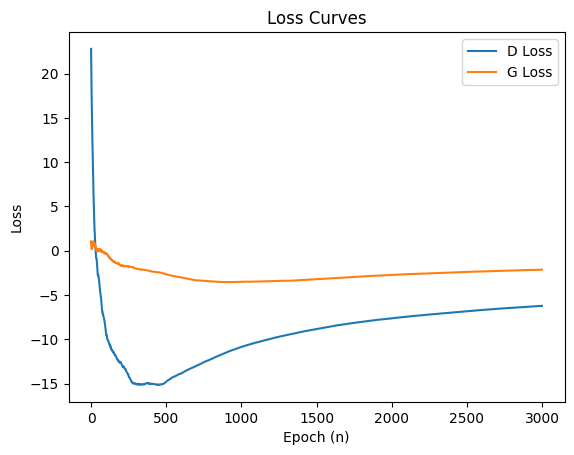

In [20]:
errD =model.avg_train_loss_D
errG =model.avg_train_loss_G

plt.figure()
plt.plot(np.arange(0,epochs), errD, label='D Loss')
plt.plot(np.arange(0,epochs), errG, label='G Loss')
plt.legend()
plt.title('Loss Curves')
plt.xlabel('Epoch (n)')
plt.ylabel('Loss')
plt.show()

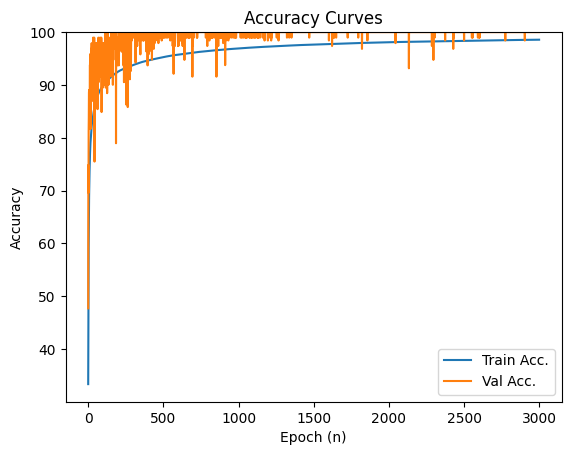

In [21]:
train_acc = model.avg_train_accuracy
val_acc   = model.val_accuracy

plt.figure()
plt.plot(np.arange(0,epochs), train_acc, label='Train Acc.')
plt.plot(np.arange(0,epochs), val_acc, label='Val Acc.')
plt.legend()
plt.title('Accuracy Curves')
plt.xlabel('Epoch (n)')
plt.ylabel('Accuracy')
plt.ylim([None,100])
plt.show()

In [27]:
### Evaluate after training
eval_noise = torch.randn((batch_size, z_dim, 1, 1))#np.random.normal(0, 1, (self.batch_size, self.z_dim))#torch.rand((self.batch_size, 128, 1, 1))
eval_noise = model.get_torch_variable(eval_noise)

eval_label = torch.randint(0, n_classes, (batch_size,))
eval_label = model.get_torch_variable(eval_label)

model.D.eval()
model.G.eval()

 # Denormalize images and save them in grid 8x8
samples = model.G(eval_noise, eval_label)
samples = samples.mul(0.5).add(0.5).clamp(0,1)
samples = samples.data.cpu()
grid = utils.make_grid(samples)
utils.save_image(grid, 'output_example.png')

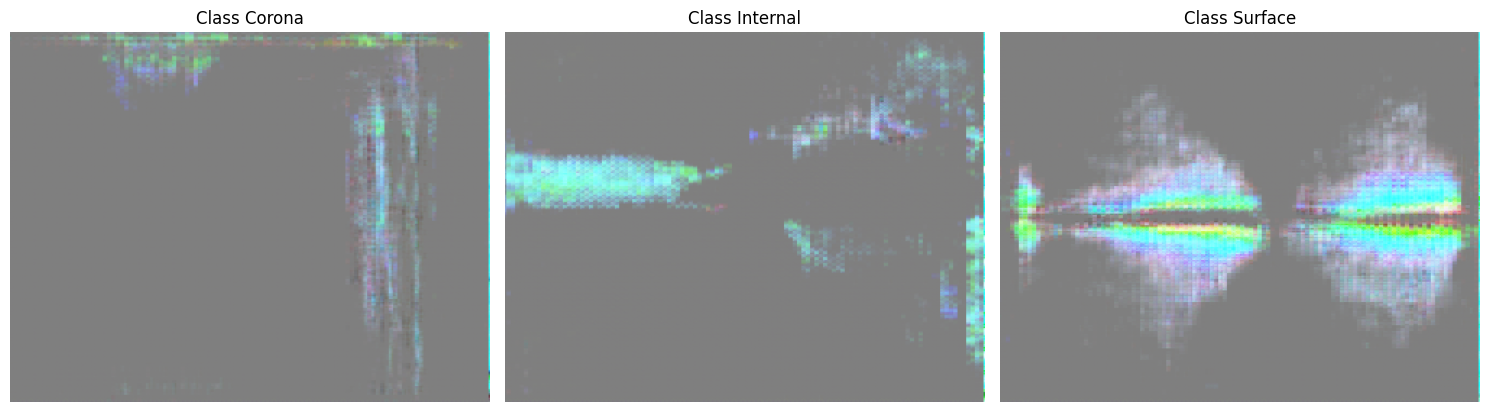

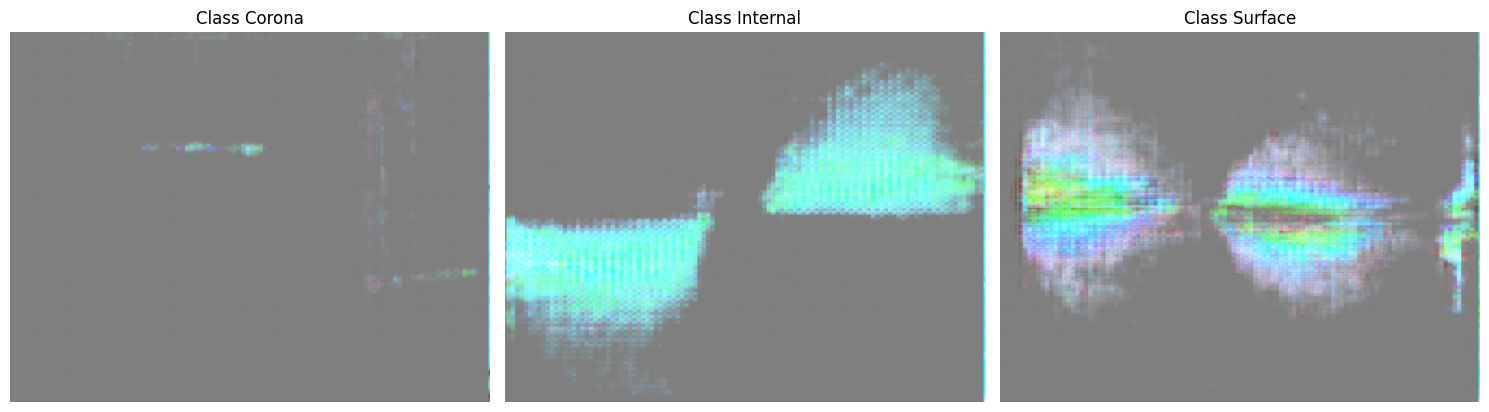

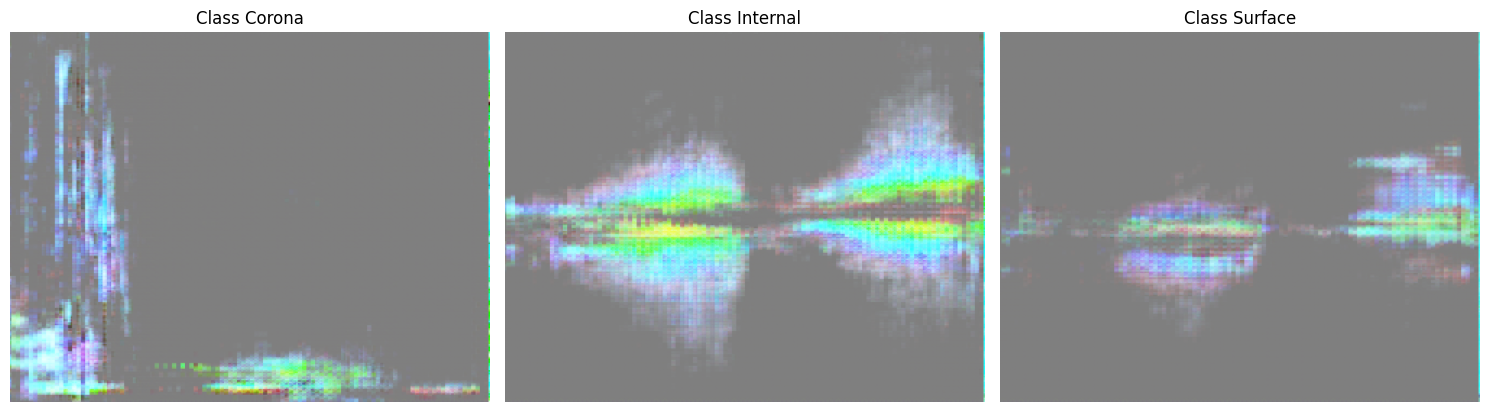

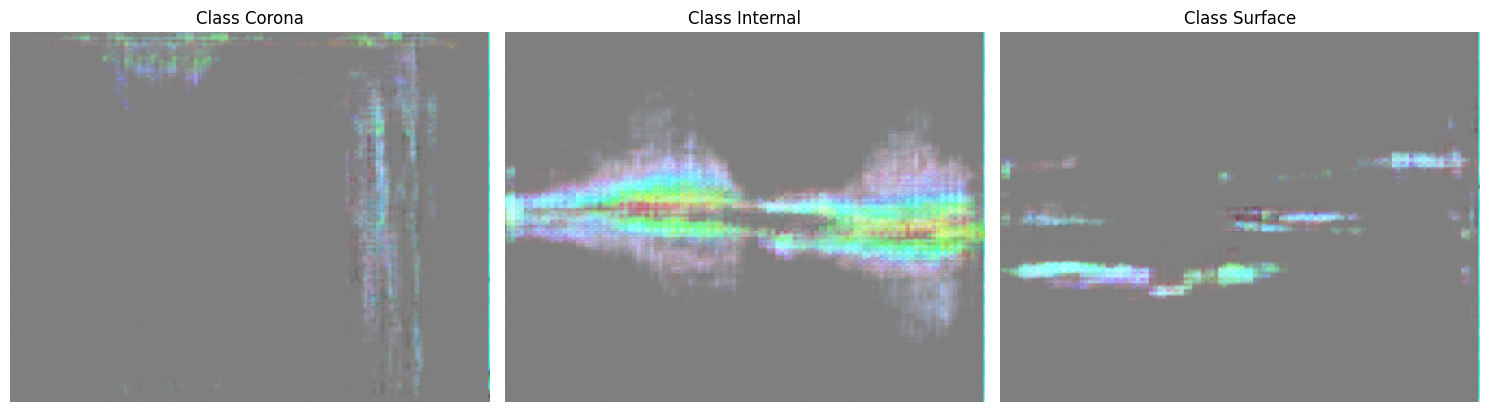

In [23]:
for idx in [1,2,3,4]:

    example_label1 = samples[torch.where(eval_label == 0)[0][idx]].permute(1, 2, 0).numpy()
    example_label2 = samples[torch.where(eval_label == 1)[0][idx]].permute(1, 2, 0).numpy()
    example_label3 = samples[torch.where(eval_label == 2)[0][idx]].permute(1, 2, 0).numpy()
    
    # Create a single figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed
    
    # Display the first image
    axes[0].imshow(example_label1)
    axes[0].axis('off')
    axes[0].set_title('Class Corona')
    
    # Display the second image
    axes[1].imshow(example_label2)
    axes[1].axis('off')
    axes[1].set_title('Class Internal')
    
    # Display the third image
    axes[2].imshow(example_label3)
    axes[2].axis('off')
    axes[2].set_title('Class Surface')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Show the combined plot
    plt.show()

In [24]:
out = []
labels = []
for _ in range(10):

    eval_noise = torch.randn((batch_size, z_dim, 1, 1))
    eval_noise = model.get_torch_variable(eval_noise)
    
    eval_label = torch.randint(0, n_classes, (batch_size,))
    eval_label = model.get_torch_variable(eval_label)
    
    model.D.eval()
    model.G.eval()
    
     # Denormalize images and save them in grid 8x8
    samples = model.G(eval_noise, eval_label)
    samples = samples.mul(0.5).add(0.5).clamp(0,1)
    samples = samples.data.cpu()
    out.append(samples)
    labels.append(eval_label)

out_tensor = torch.cat((out[0], out[1], out[2]), dim= 0)
labels = torch.cat((labels[0], labels[1], labels[2]), dim=0)

In [25]:
compare_ds = CustomDataset(out_tensor, labels)
compare_loader = DataLoader(dataset=compare_ds, batch_size=1, shuffle=False)

test_dataset = ImageDataset(test_df, transform=val_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [26]:
fid_score, kid_score, precision_score, recall_score = model.calculate_similarities(compare_loader, test_loader)

print('FID: {:.4f}'.format(fid_score))
print('KID: {:.4f}'.format(kid_score))
print('P&R: ({:.4f}, {:.4f})'.format(precision_score, recall_score))

FID: 214.5494
KID: 0.1618
P&R: (0.0000, 0.0000)
